In [200]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.


['database.sqlite', 'Tweets.csv']


In [201]:
import os

# Time
import time
import datetime

# Numerical
import numpy as np
import pandas as pd

# Tools
import itertools
from collections import Counter

# NLP
import re
import nltk
from nltk.corpus import stopwords

# Preprocessing
from sklearn import preprocessing
from sklearn.utils import class_weight as cw
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Model Selection
from sklearn.model_selection import train_test_split

# Evaluation Metrics
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report

# Deep Learing Preprocessing - Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical

# Deep Learning Model - Keras
from keras.models import Model
from keras.models import Sequential

from keras.layers import Dense, Embedding
from keras.models import Sequential

# Deep Learning Model - Keras - RNN
from keras.layers import Embedding, LSTM, Bidirectional

# Deep Learning Model - Keras - General
from keras.layers import Input, Add, concatenate, Dense, Activation, BatchNormalization, Dropout, Flatten
from keras.layers import LeakyReLU, PReLU, Lambda, Multiply

from keras.preprocessing import sequence

# Deep Learning Parameters - Keras
from keras.optimizers import RMSprop, Adam

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [202]:
path = Path(os.path.abspath(os.curdir))

In [203]:
#File Import
filepath = Path('../input')
df = pd.read_csv(filepath/'Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [204]:
df_dplr = df[['text','airline_sentiment']]
df_dplr.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [205]:
df_dplr = df_dplr.reindex(np.random.permutation(df_dplr.index))
df_dplr.head()

,text,airline_sentiment
13872,@AmericanAir she doesn't have Twitter.,neutral
5592,@SouthwestAir how many left?! I'm 15 min wway,neutral
2967,@united deserves to go bankrupt. Just delayed ...,negative
7387,@JetBlue Why are you making it so freaking har...,negative
5055,@SouthwestAir I was under the impression when ...,neutral


In [206]:
#Text Pre-processing
def text_cleaning(tweet):
    letters = re.sub("[^a-zA-Z]"," ",tweet)
    ht = re.sub(r'http\S+', '',letters)
    mention = re.sub(r'@\w+', '', ht)
    p = re.sub(r'[^\w\s]','',mention)
    words = p.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return( " ".join(meaningful_words))
df_dplr['text_clean']=df_dplr['text'].apply(lambda x: text_cleaning(x))

In [207]:
Y = df_dplr['airline_sentiment']
lenc = LabelEncoder()
Y = lenc.fit_transform(Y)
Y = to_categorical(Y)

In [208]:
#Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(df_dplr['text_clean'], Y, test_size=0.2,random_state=37)

In [209]:
max_words = len(set(" ".join(X_train).split()))
max_len = X_train.apply(lambda x: len(x)).max()
max_words, max_len

(11950, 142)

In [210]:
#Tokenizer 
tk = Tokenizer(num_words=max_words)
tk.fit_on_texts(X_train)
X_train_tk = tk.texts_to_sequences(X_train)
X_test_tk = tk.texts_to_sequences(X_test)

In [211]:
#Padding sequences
X_train_pad = sequence.pad_sequences(X_train_tk, maxlen=max_len)
X_test_pad = sequence.pad_sequences(X_test_tk, maxlen = max_len)

In [212]:
num_classes = 3

In [213]:
#Class weights Implementation for unbalanced dataset
def get_weight(y):
    class_weight_current =  cw.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current
class_weight = get_weight(Y_train.flatten())
print(class_weight)

[0.75 1.5 ]


In [214]:
def deep_lr_model(model):
    batch_size = 256
    epochs = 10
    optimizers = Adam(0.03)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_pad, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_pad,Y_test), verbose=1,class_weight=class_weight)
    return history

In [215]:
#base model
model = Sequential()
model.add(Embedding(max_words,128,input_length=max_len))
model.add(LSTM(128))
model.add(Dense(num_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 142, 128)          1529600   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 1,661,571
Trainable params: 1,661,571
Non-trainable params: 0
_________________________________________________________________


In [216]:
deep_lr_model(model)

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 15s 1ms/step - loss: 0.9264 - acc: 0.6204 - val_loss: 0.8206 - val_acc: 0.6288
Epoch 2/10
11712/11712 [==============================] - 14s 1ms/step - loss: 0.6967 - acc: 0.6831 - val_loss: 0.6089 - val_acc: 0.7319
Epoch 3/10
11712/11712 [==============================] - 14s 1ms/step - loss: 0.4462 - acc: 0.8257 - val_loss: 0.5501 - val_acc: 0.7736
Epoch 4/10
11712/11712 [==============================] - 14s 1ms/step - loss: 0.2906 - acc: 0.8918 - val_loss: 0.5786 - val_acc: 0.7801
Epoch 5/10
11712/11712 [==============================] - 14s 1ms/step - loss: 0.2084 - acc: 0.9261 - val_loss: 0.6692 - val_acc: 0.7770
Epoch 6/10
11712/11712 [==============================] - 14s 1ms/step - loss: 0.1595 - acc: 0.9447 - val_loss: 0.7036 - val_acc: 0.7715
Epoch 7/10
11712/11712 [==============================] - 14s 1ms/step - loss: 0.1382 - acc: 0.9524 - val_loss: 0.7925 - val_acc:

In [217]:
#Adding dropout
model1 = Sequential()
model1.add(Embedding(max_words,128,input_length=max_len))
model1.add(LSTM(128))
model1.add(Dropout(0.4))
model1.add(Dense(num_classes, activation='sigmoid'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 142, 128)          1529600   
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 1,661,571
Trainable params: 1,661,571
Non-trainable params: 0
_________________________________________________________________


In [218]:
deep_lr_model(model1)

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 15s 1ms/step - loss: 0.9254 - acc: 0.6190 - val_loss: 0.7677 - val_acc: 0.6609
Epoch 2/10
11712/11712 [==============================] - 13s 1ms/step - loss: 0.6554 - acc: 0.7328 - val_loss: 0.6036 - val_acc: 0.7442
Epoch 3/10
11712/11712 [==============================] - 13s 1ms/step - loss: 0.4734 - acc: 0.8212 - val_loss: 0.5643 - val_acc: 0.7715
Epoch 4/10
11712/11712 [==============================] - 13s 1ms/step - loss: 0.3307 - acc: 0.8795 - val_loss: 0.5831 - val_acc: 0.7780
Epoch 5/10
11712/11712 [==============================] - 13s 1ms/step - loss: 0.2515 - acc: 0.9104 - val_loss: 0.6480 - val_acc: 0.7913
Epoch 6/10
11712/11712 [==============================] - 13s 1ms/step - loss: 0.1925 - acc: 0.9324 - val_loss: 0.6641 - val_acc: 0.7783
Epoch 7/10
11712/11712 [==============================] - 13s 1ms/step - loss: 0.1576 - acc: 0.9463 - val_loss: 0.7203 - val_acc:

In [219]:
#Adding regularizer 
model2 = Sequential()
model2.add(Embedding(max_words,128,input_length=max_len))
model2.add(Dropout(0.4))
model2.add(LSTM(128,kernel_regularizer=regularizers.l2(0.001)))
model2.add(Dense(num_classes, activation='sigmoid'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 142, 128)          1529600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 142, 128)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 387       
Total params: 1,661,571
Trainable params: 1,661,571
Non-trainable params: 0
_________________________________________________________________


In [220]:
deep_lr_model(model2)

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 15s 1ms/step - loss: 1.0556 - acc: 0.6193 - val_loss: 0.9455 - val_acc: 0.6288
Epoch 2/10
11712/11712 [==============================] - 13s 1ms/step - loss: 0.8049 - acc: 0.6635 - val_loss: 0.6785 - val_acc: 0.7039
Epoch 3/10
11712/11712 [==============================] - 14s 1ms/step - loss: 0.5665 - acc: 0.7821 - val_loss: 0.5819 - val_acc: 0.7790
Epoch 4/10
11712/11712 [==============================] - 13s 1ms/step - loss: 0.4578 - acc: 0.8432 - val_loss: 0.5705 - val_acc: 0.7821
Epoch 5/10
11712/11712 [==============================] - 13s 1ms/step - loss: 0.3464 - acc: 0.8817 - val_loss: 0.5996 - val_acc: 0.7688
Epoch 6/10
11712/11712 [==============================] - 13s 1ms/step - loss: 0.2859 - acc: 0.9051 - val_loss: 0.6299 - val_acc: 0.7927
Epoch 7/10
11712/11712 [==============================] - 13s 1ms/step - loss: 0.2375 - acc: 0.9238 - val_loss: 0.6617 - val_acc:

In [227]:
score = model.evaluate(X_test_pad,Y_test)
score1 = model1.evaluate(X_test_pad,Y_test)
score2 = model2.evaluate(X_test_pad,Y_test)

2928/2928 [==============================] - 9s 3ms/step


In [230]:
print("Test Accuracy of Base Model:",score[1])
print("Test Accuracy of Base Model with Dropout Layer:",score1[1])
print("Test Accuracy of Base Model with Dropout Layer and Regularizer:",score2[1])

Test Accuracy of Base Model: 0.7694672131147541
Test Accuracy of Base Model with Dropout Layer: 0.7588797814207651
Test Accuracy of Base Model with Dropout Layer and Regularizer: 0.7612704918032787


## Transfer Learning
#### Loading pre-trained language model and fine-tuning

In [231]:
df = df[['airline_sentiment','text']]
df.head(2)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...


In [232]:
train = df[:int(len(df)*.99)]
valid = df[int(len(df)*.99):]

In [233]:
lm_dat = TextLMDataBunch.from_df(path, train, valid)
lm_dat.save('data_lm_export.pkl')

In [234]:
lm_learn = language_model_learner(lm_dat, AWD_LSTM, drop_mult=0.4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


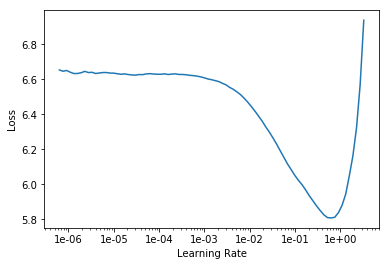

In [235]:
lm_learn.lr_find()
lm_learn.recorder.plot()

In [236]:
lm_learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.178373,4.132653,0.230134,00:07
1,4.211199,3.884747,0.250893,00:07
2,3.823241,3.827410,0.255134,00:07
3,3.629788,3.811810,0.255804,00:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


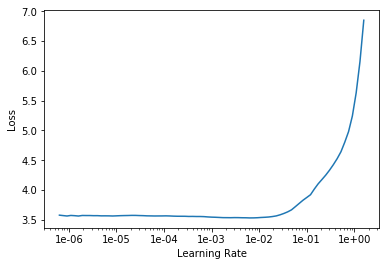

In [237]:
lm_learn.unfreeze()
lm_learn.lr_find(); lm_learn.recorder.plot()

In [238]:
lm_learn.fit_one_cycle(4, 1e-3)
#Encoder
lm_learn.save_encoder('ft_enc')

epoch,train_loss,valid_loss,accuracy,time
0,3.497260,3.789087,0.254911,00:09
1,3.366125,3.695282,0.278795,00:09
2,3.161080,3.714090,0.273438,00:09
3,2.985224,3.748913,0.272098,00:09


## Fine-tuning Classifier 


In [239]:
#Splitting the dataset in 80:20 ratio
train = df[:int(len(df)*.80)]
valid = df[int(len(df)*.80):]

In [240]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path, train, valid, vocab=lm_dat.train_ds.vocab, bs=32)
data_clas.save('data_clas_export.pkl') ; data_clas = load_data(path, 'data_clas_export.pkl', bs=16)

In [241]:
#Building a classifier with fine-tuned encoder 
lm_learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=.3, metrics=[accuracy,Precision(average='weighted'),Recall(average='weighted')])
lm_learn.load_encoder('ft_enc')

In [242]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @united - xxup seriously it 's 2015 ? ! ? ! xxup no wifi on a 5hr flight from xxup cle - xxup sfo # 1589 . xxmaj you 're the xxup only airline w / out wifi ... and pls no ' xxunk ' xxup bs .,negative
"xxbos @southwestair i had to travel to xxmaj savannah , xxup ga , once again , on an airline i do n't "" xxmaj luv "" . xxmaj when r u going to fly me to xxmaj savannah ? xxmaj pl xxrep 4 e ase xxrep 4 !",neutral
"xxbos xxup by xxup the xxup grace xxup of xxup god , i xxup made xxup it ! “ @usairways : xxup xxunk _ _ xxmaj we do n't have those xxunk in here . xxmaj we hope you can make that flight . ”",positive
"xxbos xxup @usairways xxup are xxup you xxup kidding xxup me ? ? xxmaj bad customer service , folks . xxmaj flew from xxup psp to xxup phx flight 2692 on 2 / 19 . ( cont ) http : / / t.co / xxunk",negative


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


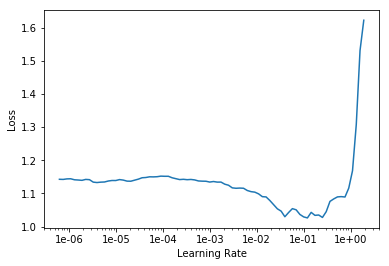

In [243]:
lm_learn.lr_find()
lm_learn.recorder.plot()

In [244]:
lm_learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.702762,0.491912,0.810451,0.803543,0.810451,00:16
1,0.617594,0.492713,0.804986,0.788722,0.804986,00:15
2,0.615376,0.483792,0.805328,0.799519,0.805328,00:15
3,0.619379,0.470546,0.811134,0.798891,0.811134,00:15


In [245]:
lm_learn.freeze_to(-2)
lm_learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.587489,0.454232,0.820014,0.806209,0.820014,00:17
1,0.561773,0.480046,0.824454,0.813768,0.824454,00:17
2,0.529761,0.441506,0.830260,0.818620,0.830260,00:18
3,0.511858,0.439560,0.828552,0.817151,0.828552,00:18


In [246]:
#unfreezing the model and fine-tuning it
lm_learn.unfreeze()
lm_learn.fit_one_cycle(8, slice(1e-5/(2.6**4),1e-5))
lm_learn.save('final')

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.480101,0.433635,0.833333,0.822101,0.833333,00:27
1,0.520354,0.444003,0.830260,0.818088,0.830260,00:26
2,0.504832,0.468070,0.828552,0.816856,0.828552,00:26
3,0.454267,0.462897,0.830260,0.819464,0.830260,00:27
4,0.494043,0.700758,0.828552,0.818089,0.828552,00:26
5,0.454373,0.467475,0.830601,0.819705,0.830601,00:26
6,0.503702,0.436918,0.835041,0.824259,0.835041,00:26
7,0.453251,0.434388,0.831626,0.821117,0.831626,00:27


In [248]:
#Obtaining Test Accuracy
valid['pred_sentiment'] = valid['text'].apply(lambda row: str(lm_learn.predict(row)[0]))
print("Test Accuracy: ", accuracy_score(valid['airline_sentiment'], valid['pred_sentiment']))

Test Accuracy:  0.832308743169399


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [249]:
#Creation of list of tweets
tweets_donald_trump = ["Very disappointed in Prime Minister Stefan Löfven for being unable to act. Sweden has let our African American Community down in the United States. I watched the tapes of A$AP Rocky, and he was being followed and harassed by troublemakers. Treat Americans fairly! #FreeRocky",
       "I am pleased to announce the House has passed our budget deal 284-149. Great for our Military and our Vets. A big thank you!",
       "This has been a disaster for the Democrats and a disaster for the reputation of Robert Mueller.” Chris Wallace @FoxNews",
       "The Democrat Congresswomen have been spewing some of the most vile, hateful, and disgusting things ever said by a politician in the House or Senate, & yet they get a free pass and a big embrace from the Democrat Party. Horrible anti-Israel, anti-USA, pro-terrorist & public.....",
       ".....shouting of the F...word, among many other terrible things, and the petrified Dems run for the hills. Why isn’t the House voting to rebuke the filthy and hate laced things they have said? Because they are the Radical Left, and the Democrats are afraid to take them on. Sad!",
       "94% Approval Rating in the Republican Party, an all time high. Ronald Reagan was 87%. Thank you!",
       "Mexico is doing great at the Border, but China is letting us down in that they have not been buying the agricultural products from our great Farmers that they said they would. Hopefully they will start soon!",
        "Watched low rated @Morning_Joe for first time in long time. FAKE NEWS. He called me to stop a National Enquirer article. I said no! Bad show",
       "Great morning at the Pentagon yesterday. Congratulations to our new Defense Secretary, Mark @EsperDoD!",
       "Highly conflicted Robert Mueller should not be given another bite at the apple. In the end it will be bad for him and the phony Democrats in Congress who have done nothing but waste time on this ridiculous Witch Hunt. Result of the Mueller Report, NO COLLUSION, NO OBSTRUCTION!..."]

In [250]:
#Creating a dataframe
df_djt = pd.DataFrame(tweets_donald_trump,columns=['Donald Trump Tweets'])

In [251]:
#Prediction of sentiment of Dataframe's tweets
df_djt['pred_sentiment'] = df_djt['Donald Trump Tweets'].apply(lambda row: str(lm_learn.predict(row)[0]))
df_djt

,Donald Trump Tweets,pred_sentiment
0,Very disappointed in Prime Minister Stefan Löf...,negative
1,I am pleased to announce the House has passed ...,positive
2,This has been a disaster for the Democrats and...,negative
3,The Democrat Congresswomen have been spewing s...,negative
4,".....shouting of the F...word, among many othe...",negative
5,"94% Approval Rating in the Republican Party, a...",positive
6,"Mexico is doing great at the Border, but China...",neutral
7,Watched low rated @Morning_Joe for first time ...,negative
8,Great morning at the Pentagon yesterday. Congr...,positive
9,Highly conflicted Robert Mueller should not be...,negative


## Conclusion
The observed test accuracy for models implemented were as follows:

* Test Accuracy of simple LSTM Model: 76.94%
* Test Accuracy of Base Model with Dropout Layer: 75.88%
* Test Accuracy of Base Model with Dropout Layer and Regularizer: 76.12%
* Test Accuracy of Classifier after using Pre-trained model: 83.23%

**The Test Accuracy has significantly improved after using transfer learning.  **

## References
[1] “Application to NLP, including ULMFiT fine-tuning,” text | fastai. [Online]. Available: https://docs.fast.ai/text.html#Text-models,-data,-and-training. [Accessed: 24-Jul-2019].
